In [1]:
# This tutorial will briefly show the how to build a DMDc model from the aerodynamic data.
# We will create the database, create the physical model, and finally use them to obtain the ROM.
# We will then plot the eigenvalues and modes of the aerodynamic system, to study how the system evolve.
# After the completion of this tutorial you should be able to obtain a surrogate model from high-fidelity
# aerodynamics, to be used to predict the behaviour of the system to different inputs.

In [2]:
# We will assume the completion of tutorial 1 in the following. Here we call the main functions of tutorial 1 that
# are required to proceed

import os
os.chdir("..")
import aerodynamics
os.chdir("Tutorials")

stru_history = "/mnt/y/SU2/BSCW/DMD_training/blendedStep/StructHistoryModal.dat"
aero_history = "/mnt/y/SU2/BSCW/DMD_training/blendedStep/surface_flow.csv"

database = aerodynamics.database(stru_history,aero_history)
model = aerodynamics.physicalModel("/mnt/y/SU2/BSCW/mappedModes/Normals.csv","/mnt/y/SU2/BSCW/mappedModes/Mode.csv")

Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file /mnt/y/SU2/BSCW/DMD_training/blendedStep/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened file 99 of 1099
Opened file 100 of 1099
Opened file 101 of 1099
Opened file 102 of 1099
Opened file 103 of 1099
Opened file 104 of 1099
Opened file 105 of 1099
Opened file 106 of 1099
Opened file 107 of 1099
Opened file 108 of 1099
Opened file 109 of 1099
Opened file 110 of 1099
Opened file 111 of 1099
Opened file 112 of 1099
Opened file 113 of 1099
Opened file 114 of 1099
Opened file 115 of 1099
Opened file 116 of 1099
Opened file 117 of 1099
Opened file 118 of 1099
Opened file 119 of 1099
Opened file 120 of 1099
Opened file 121 of 1099
Opened file 122 of 1099
Opened file 123 of 1099
Opened file 124 of 1099
Opened file 125 of 1099
Opened file 126 of 1099
Opened file 127 of 1099
Opened file 128 of 1099
Opened file 129 of 1099
Opened fi

Opened file 431 of 1099
Opened file 432 of 1099
Opened file 433 of 1099
Opened file 434 of 1099
Opened file 435 of 1099
Opened file 436 of 1099
Opened file 437 of 1099
Opened file 438 of 1099
Opened file 439 of 1099
Opened file 440 of 1099
Opened file 441 of 1099
Opened file 442 of 1099
Opened file 443 of 1099
Opened file 444 of 1099
Opened file 445 of 1099
Opened file 446 of 1099
Opened file 447 of 1099
Opened file 448 of 1099
Opened file 449 of 1099
Opened file 450 of 1099
Opened file 451 of 1099
Opened file 452 of 1099
Opened file 453 of 1099
Opened file 454 of 1099
Opened file 455 of 1099
Opened file 456 of 1099
Opened file 457 of 1099
Opened file 458 of 1099
Opened file 459 of 1099
Opened file 460 of 1099
Opened file 461 of 1099
Opened file 462 of 1099
Opened file 463 of 1099
Opened file 464 of 1099
Opened file 465 of 1099
Opened file 466 of 1099
Opened file 467 of 1099
Opened file 468 of 1099
Opened file 469 of 1099
Opened file 470 of 1099
Opened file 471 of 1099
Opened file 472 

Opened file 773 of 1099
Opened file 774 of 1099
Opened file 775 of 1099
Opened file 776 of 1099
Opened file 777 of 1099
Opened file 778 of 1099
Opened file 779 of 1099
Opened file 780 of 1099
Opened file 781 of 1099
Opened file 782 of 1099
Opened file 783 of 1099
Opened file 784 of 1099
Opened file 785 of 1099
Opened file 786 of 1099
Opened file 787 of 1099
Opened file 788 of 1099
Opened file 789 of 1099
Opened file 790 of 1099
Opened file 791 of 1099
Opened file 792 of 1099
Opened file 793 of 1099
Opened file 794 of 1099
Opened file 795 of 1099
Opened file 796 of 1099
Opened file 797 of 1099
Opened file 798 of 1099
Opened file 799 of 1099
Opened file 800 of 1099
Opened file 801 of 1099
Opened file 802 of 1099
Opened file 803 of 1099
Opened file 804 of 1099
Opened file 805 of 1099
Opened file 806 of 1099
Opened file 807 of 1099
Opened file 808 of 1099
Opened file 809 of 1099
Opened file 810 of 1099
Opened file 811 of 1099
Opened file 812 of 1099
Opened file 813 of 1099
Opened file 814 

Opened file 1 of 2
Completed reading
Done


In [3]:
# The creation of the rom is a simple one-line statement. 
rom = aerodynamics.ROM([database],model)
# This contains the matrices A and B that are used
# to advance the system in time following x^n+1 = Ax^n + Bu^n

In [5]:
# We can now perform an eigenvalue analysis of the A matrix to obtain the DMD aerodynamic modes.
import numpy as np
w, v = np.linalg.eig(rom.A)

In [16]:
# The first sanity check that we can perform is to reproduce the training data

# We set the initial condition of the ROM (it is automatically set to the last snapshot, so we need to change it)
rom._ROM__setInitialCondition(database.X[:,0].reshape((database.X.shape[0], 1)))

lift = []
# Then we iterate for the number of total time iterations, providing to the rom the same inputs of the full model
for i in range(len(database.timeIter)):
    print("Time iteration {} of {}".format(i,len(database.timeIter)))
    
    # With the predict function we compute the new time level aerodynamic state. It also provides as input the corresponding
    # modal forces. It receives as input the structural modal amplitudes.
    modalForces = rom.predict(database.U[:,i])
    
    # With the update function, we advance the state inside the class ROM
    rom.update()
    
    # We can now access the new state as rom.X. Please remember that this is the reduced state, thus in order to get
    # the full one we must multiply for the PODs of the physical state and add the mean flow.
    # If we directly pass this full state to the physical model we can obtain the lift.
    lift = np.append(lift, model.getCl(rom.Up.dot(rom.X)+rom.Xmean))
    

Time iteration 0 of 1001
Time iteration 1 of 1001
Time iteration 2 of 1001
Time iteration 3 of 1001
Time iteration 4 of 1001
Time iteration 5 of 1001
Time iteration 6 of 1001
Time iteration 7 of 1001
Time iteration 8 of 1001
Time iteration 9 of 1001
Time iteration 10 of 1001
Time iteration 11 of 1001
Time iteration 12 of 1001
Time iteration 13 of 1001
Time iteration 14 of 1001
Time iteration 15 of 1001
Time iteration 16 of 1001
Time iteration 17 of 1001
Time iteration 18 of 1001
Time iteration 19 of 1001
Time iteration 20 of 1001
Time iteration 21 of 1001
Time iteration 22 of 1001
Time iteration 23 of 1001
Time iteration 24 of 1001
Time iteration 25 of 1001
Time iteration 26 of 1001
Time iteration 27 of 1001
Time iteration 28 of 1001
Time iteration 29 of 1001
Time iteration 30 of 1001
Time iteration 31 of 1001
Time iteration 32 of 1001
Time iteration 33 of 1001
Time iteration 34 of 1001
Time iteration 35 of 1001
Time iteration 36 of 1001
Time iteration 37 of 1001
Time iteration 38 of 1

Time iteration 308 of 1001
Time iteration 309 of 1001
Time iteration 310 of 1001
Time iteration 311 of 1001
Time iteration 312 of 1001
Time iteration 313 of 1001
Time iteration 314 of 1001
Time iteration 315 of 1001
Time iteration 316 of 1001
Time iteration 317 of 1001
Time iteration 318 of 1001
Time iteration 319 of 1001
Time iteration 320 of 1001
Time iteration 321 of 1001
Time iteration 322 of 1001
Time iteration 323 of 1001
Time iteration 324 of 1001
Time iteration 325 of 1001
Time iteration 326 of 1001
Time iteration 327 of 1001
Time iteration 328 of 1001
Time iteration 329 of 1001
Time iteration 330 of 1001
Time iteration 331 of 1001
Time iteration 332 of 1001
Time iteration 333 of 1001
Time iteration 334 of 1001
Time iteration 335 of 1001
Time iteration 336 of 1001
Time iteration 337 of 1001
Time iteration 338 of 1001
Time iteration 339 of 1001
Time iteration 340 of 1001
Time iteration 341 of 1001
Time iteration 342 of 1001
Time iteration 343 of 1001
Time iteration 344 of 1001
T

Time iteration 612 of 1001
Time iteration 613 of 1001
Time iteration 614 of 1001
Time iteration 615 of 1001
Time iteration 616 of 1001
Time iteration 617 of 1001
Time iteration 618 of 1001
Time iteration 619 of 1001
Time iteration 620 of 1001
Time iteration 621 of 1001
Time iteration 622 of 1001
Time iteration 623 of 1001
Time iteration 624 of 1001
Time iteration 625 of 1001
Time iteration 626 of 1001
Time iteration 627 of 1001
Time iteration 628 of 1001
Time iteration 629 of 1001
Time iteration 630 of 1001
Time iteration 631 of 1001
Time iteration 632 of 1001
Time iteration 633 of 1001
Time iteration 634 of 1001
Time iteration 635 of 1001
Time iteration 636 of 1001
Time iteration 637 of 1001
Time iteration 638 of 1001
Time iteration 639 of 1001
Time iteration 640 of 1001
Time iteration 641 of 1001
Time iteration 642 of 1001
Time iteration 643 of 1001
Time iteration 644 of 1001
Time iteration 645 of 1001
Time iteration 646 of 1001
Time iteration 647 of 1001
Time iteration 648 of 1001
T

Time iteration 916 of 1001
Time iteration 917 of 1001
Time iteration 918 of 1001
Time iteration 919 of 1001
Time iteration 920 of 1001
Time iteration 921 of 1001
Time iteration 922 of 1001
Time iteration 923 of 1001
Time iteration 924 of 1001
Time iteration 925 of 1001
Time iteration 926 of 1001
Time iteration 927 of 1001
Time iteration 928 of 1001
Time iteration 929 of 1001
Time iteration 930 of 1001
Time iteration 931 of 1001
Time iteration 932 of 1001
Time iteration 933 of 1001
Time iteration 934 of 1001
Time iteration 935 of 1001
Time iteration 936 of 1001
Time iteration 937 of 1001
Time iteration 938 of 1001
Time iteration 939 of 1001
Time iteration 940 of 1001
Time iteration 941 of 1001
Time iteration 942 of 1001
Time iteration 943 of 1001
Time iteration 944 of 1001
Time iteration 945 of 1001
Time iteration 946 of 1001
Time iteration 947 of 1001
Time iteration 948 of 1001
Time iteration 949 of 1001
Time iteration 950 of 1001
Time iteration 951 of 1001
Time iteration 952 of 1001
T

/tmp/ipykernel_585/2669054424.py:13: UserWarning: Legend does not support 'R' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("ROM","Full model")
/tmp/ipykernel_585/2669054424.py:13: UserWarning: Legend does not support 'O' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("ROM","Full model")
/tmp/ipykernel_585/2669054424.py:13: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("ROM","Full model")


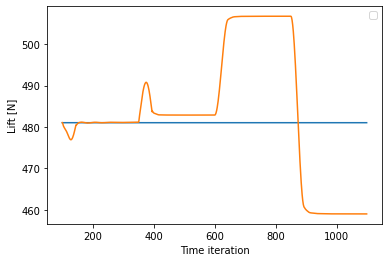

In [20]:
# We can then compute the same quantities as for tutorial 1 as a reference
lift_ref = []

for i in range(len(database.timeIter)):
    lift_ref = np.append(lift_ref, model.getCl(database.X[:,i]))

import matplotlib.pyplot as plt
plt.plot(database.timeIter, lift[0:1001])
plt.plot(database.timeIter, lift_ref)
# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Lift [N]")
plt.legend("ROM","Full model")